In [221]:
#|default_exp preprocessing

#|export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [222]:
#| export
class PolyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, data_columns, degrees=np.arange(2,7), plot=False):
        self.data_columns = data_columns
        self.degrees = degrees
        self.plot = plot
        self.poly_func = {}
        

    def fit(self, X, y=None):
        for column in self.data_columns:
            if X[column].isna().sum() == 0:
                continue
            else:
                self.poly_func[column] = self._find_best_polynomial(X[column])
        return self
    

    def transform(self, X):
        if self.poly_func is None:
            raise ValueError("PolyImputer must be fitted before calling transform.")
        
        for column in self.poly_func.keys():
            values = np.arange(len(X[column]))
            fill_value = pd.Series(self.poly_func[column](values), dtype=np.float32)
            X[column] = X[column].fillna(fill_value)
        return X
    

    def _find_best_polynomial(self, series):
        series_interpolated = series.interpolate(method='linear', limit_direction='both')
        x = np.arange(len(series_interpolated))
        y = series_interpolated.values
        dist = np.inf
        best_polynomial = None
        
        for degree in self.degrees:
            coefficients = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coefficients)
            distribution = polynomial(x)

            wasserstein_dist = wasserstein_distance(series_interpolated, distribution)
            if wasserstein_dist < dist:
                best_polynomial = polynomial
                dist = wasserstein_dist                

        if self.plot:
            self._plot_polynomial_fit(distribution, series, dist, polynomial)

        return best_polynomial
    
    
    def _plot_polynomial_fit(self, distribution, original_series, dist, polynomial):
        _, ax = plt.subplots(figsize=(20, 5))
        ax.plot(original_series.index, distribution, label=f'Degree {polynomial.order}', linewidth=2)
        ax.scatter(original_series.index, original_series, c='grey', s=10)
        
        ax.legend()
        ax.set_title(f'Polynomial fit of {original_series.name}')
        ax.set_ylim(bottom=0)
        ax.annotate(f'Degree {polynomial.order} Wasserstein distance: {dist}', xy=(0, 20))

In [223]:
# Test

data = {
    'A': [1.0, 2.0, np.nan, 4.0, 5.0],
    'B': [np.nan, 1.0, 4.0, 1.0, np.nan],
    'C': [1, 2, 3, 4, 5],  # integer column
    'D': ['a', 'b', 'c', 'd', 'e']  # string column
}
df = pd.DataFrame(data)
data_columns = ['A', 'B', 'C', 'D']

def test_fit_polyimputer():
    imputer = PolyImputer(data_columns, plot=False)
    imputer.fit(df)
    
    assert 'A' in imputer.poly_func, "'A' should be in poly_func"
    assert 'B' in imputer.poly_func, "'B' should be in poly_func"
    assert 'C' not in imputer.poly_func, "'C' should not be in poly_func"
    assert 'D' not in imputer.poly_func, "'D' should not be in poly_func"
    print("Polyimputer test_fit passed")

def test_transform_polyimputer():
    imputer = PolyImputer(data_columns, plot=False)
    imputer.fit(df)
    transformed_df = imputer.transform(df.copy())
    
    assert not transformed_df['A'].isna().any(), "'A' should not have missing values"
    assert not transformed_df['B'].isna().any(), "'B' should not have missing values"
    
    pd.testing.assert_series_equal(df['C'], transformed_df['C'])
    pd.testing.assert_series_equal(df['D'], transformed_df['D'])
    print("Polyimputer test_transform passed")

def test_fit_transform_pipeline_polyimputer():
    pipeline = Pipeline([
        ('poly_imputer', PolyImputer(data_columns, plot=True))
    ])
    transformed_df = pipeline.fit_transform(df)
    
    assert not transformed_df['A'].isna().any(), "'A' should not have missing values"
    assert not transformed_df['B'].isna().any(), "'B' should not have missing values"
    print("Polyimputer test_fit_transform_pipeline passed")

In [224]:
#| export

class BackForwardFillMissing(BaseEstimator, TransformerMixin):
    def __init__(self, data_columns):
        self.data_columns = data_columns
        

    def fit(self, X, y=None):
        # This imputer does not need to fit anything model-specific
        return self

    def transform(self, X):
        for column in self.data_columns:
            if X[column].isna().sum() == 0:
                continue
            else:
                X[column] = ((X[column].ffill()) + X[column].bfill())/2
        X = X.dropna()
        return X

In [225]:
# Test

transform = BackForwardFillMissing(data_columns=['A', 'B'])

def test_missing_values_BFFill():
    """Test missing values surrounded by non-missing values."""
    df = pd.DataFrame({
        'A': [1, None, None, 4],
        'B': [5, 6, 7, 8]
    })
    expected_df = pd.DataFrame({
        'A': [1, (1+4)/2, (1+4)/2, 4],
        'B': [5, 6, 7, 8]
    })
    
    transformed_df = transform.fit_transform(df)
    pd.testing.assert_frame_equal(expected_df, transformed_df)
    print("BackForwardFillMissing missing values test passed")



/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_9016/2435709266.py:38: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfi

Polyimputer test_fit passed
Polyimputer test_transform passed
Polyimputer test_fit_transform_pipeline passed
BackForwardFillMissing missing values test passed


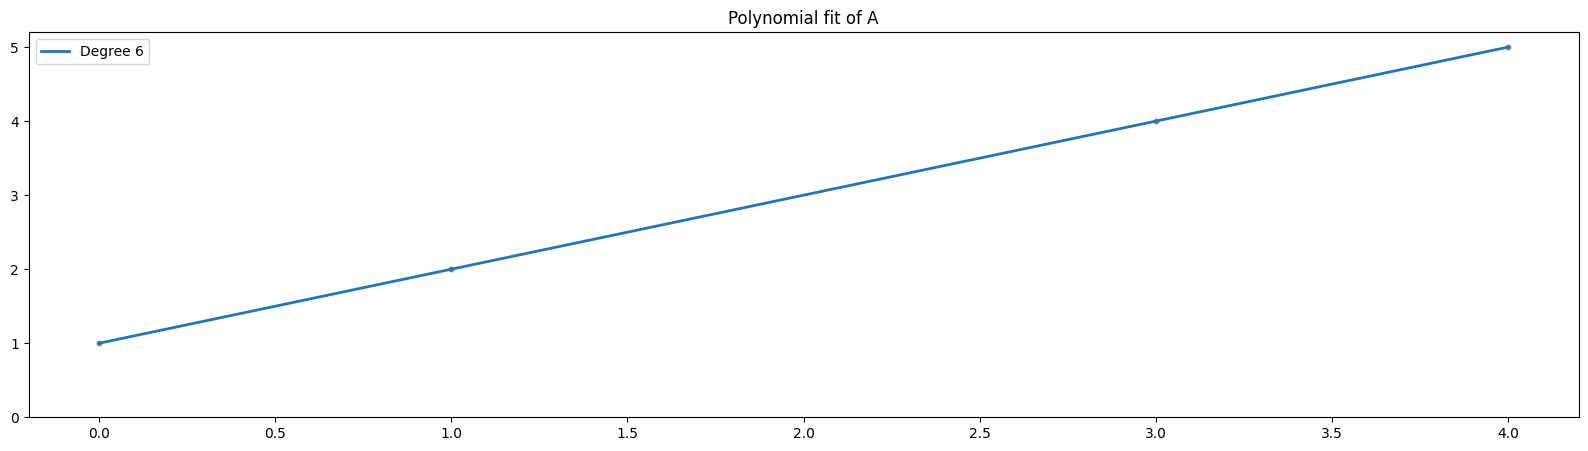

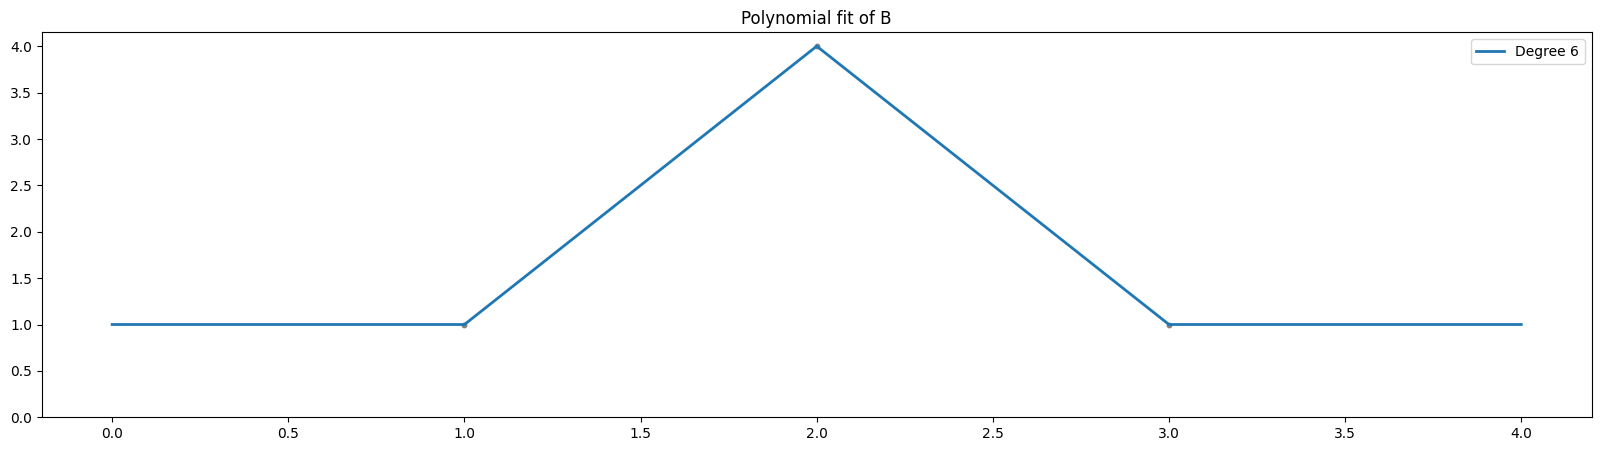

In [226]:
# hide
test_fit_polyimputer()
test_transform_polyimputer()
test_fit_transform_pipeline_polyimputer()
test_missing_values_BFFill()

In [227]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()